# Fitting a learning curve in a binary choice behavioral task

This notebook shows how to fit a behavioral learning curve in experiments where subjects learn over a number of trials to give a correct response. We assume the response is binary (i.e. correct or incorrect).

## imports and create datasets

We first do the basic imports. For some of the methods below, you need the [PyMC3](https://pymc-devs.github.io/pymc3/getting_started/) and [theano](http://deeplearning.net/software/theano/) packages. To install from a terminal: `conda install theano pymc3`

### Create a trial dataset from the animal sequence visit of regions in the maze.

Tasks is a dictionary of rules/patterns for often used behavioral paradigms. for each task a dictionary with outcomes (a list of trial outcome labels) and patterns has to be specified. The patterns are dictionaries of regular expressions in which outcomes need to be in curly braces (this will make sure that we can perform string formatting to replace the outcome labels with the encoded single symbol outcomes later.

For each pattern you need to specify a list of regular expressions. The regular expressions should be constructed such that the last match corresponds to the trial of interest.

Below, for the fan maze, patterns are defined for detecting certain trial types and for correct trials. As an example: for outbound_trials the pattern will match each trial where the animal is in the reference arm and has visited a choice arm before. For outbound_success, the pattern detects all outbound_trials for which the future response is correct.

Incomplete patterns are the beginning of a session are not considered (e.g. on the fan maze, the first visit to an arm after being put on the maze is not considered a success/failure).

Pattern available :

- tasks["fan-maze"] : "continuous-alternation-4arm-maze"
- tasks["w-maze"] : "continuous-alternation-3arm-maze"
- tasks["e-maze"] : "continuous-alternation-3arm-maze"
- tasks["sequence4"] : "continuous-sequence-4arm-maze"


The different category extracted from these patterns : 

**inbound trials**: the animal is currently NOT in the reference arm

**successful inbound trial**: the animal is currently NOT in the reference arm and will visit the reference arm next.

**outbound trials**: the animal is currently in the reference arm and had previously visited one of the choice arms

**successful outbound trial**: the animal is currently in the reference arm, has previously visited one of the choice arms, and will visit the other choice arm next.

**revisit trials**: the animal is currently in one of the 4 arms and will leave and come back to the same arm, without visiting any of the other reward sites.

**choice trials**: similar to outbound trials, but specific to one of the choices

> **_NOTE:_** Each category will return the indices, ***zero based***, of the matching trial.

This example is based on a W maze where the reference is the C branch  and the two choices are the right branch (R) or left branch (L). Below we can see the choice of the animal for each trial in one session.

In [ ]:
trials = ["C","C","C", "L", "C", "R", "C", "C", "C", "R", "C", "C", "C", "L"]

In [ ]:
import fklab.behavior.task_analysis as task_analysis
import numpy as np

task = task_analysis.tasks["w-maze"]
print(task["description"])
outcomes = dict(reference="C", choice1="L", choice2="R")
dict_pattern = task_analysis.detect_task_patterns(trials, task, outcomes)
print("--- result ----")
print(dict_pattern)


Continuous alternation between two choice arms and a reference arm on a three arm maze
--- result ----
{'inbound_trials': [3, 5, 9], 'inbound_success': [3, 5, 9], 'outbound_trials': [4, 6, 7, 8, 10, 11, 12], 'outbound_success': [4, 12], 'revisit_trials': [0, 1, 6, 7, 10, 11], 'choice1_trials': [6, 7, 8, 10, 11, 12], 'choice1_success': [12], 'choice2_trials': [4], 'choice2_success': [4], 'alternation_trials': [5, 6]}


For the next step, the dictionary needs to be refactor in two type of informations : the trial_types (inbound or outbound) for each trial and the response (successfull or not)

In [ ]:
trials = ["C","C","C", "L", "C", "R", "C", "C", "C", "R", "C", "C", "C", "L"]

inbound_trial = np.array(dict_pattern["inbound_trials"])
outbound_trial = np.array(dict_pattern["outbound_trials"])

trial_type = np.full(len(trials), "", dtype=np.dtype("U3"))
trial_type[inbound_trial] = "in"
trial_type[outbound_trial] = "out"

success = np.array(dict_pattern["inbound_success"] + dict_pattern["outbound_success"])
response = np.zeros((len(trials),), dtype=int)
response[success] = 1

x = trial_type != ""
data = {"trial_type": list(trial_type[x]), "response": list(response[x])}

print(task["description"])
print("--- result ----")
print("Number of visits: " + str(len(trials)))
print("Number of identified trials: " + str(len(trial_type[x])))
print("Labels for all visits: " + str(trial_type))
print("Result after filtering for only identified trials: ")
print(data)

Continuous alternation between two choice arms and a reference arm on a three arm maze
--- result ----
Number of visits: 14
Number of identified trials: 10
Labels for all visits: ['' '' '' 'in' 'out' 'in' 'out' 'out' 'out' 'in' 'out' 'out' 'out' '']
Result after filtering for only identified trials: 
{'trial_type': ['in', 'out', 'in', 'out', 'out', 'out', 'in', 'out', 'out', 'out'], 'response': [1, 1, 1, 0, 0, 0, 1, 0, 0, 1]}


Notice that some visits have not been identified as a valid trial and thus didn't get a label. The reason for this is the following:  
   - **The last visit** is not identified as a trial because a trial is defined as a transition from the current position to the next one. There is no next visit in this case.
   - **The first two visits**
   in this example are outbound trials. An outbound trial has the prerequisite that the previous visit was an inbound trial. This is so that the `outbound_success` set is a strict subset of the `outbound_trials` set. Both the first and second visit do not comply with this requirement and are therefore not identified as a trial. 
> **_NOTE:_** If you are running the notebook live, go ahead and test this. Change the first `"C"` visit to a `"L"` or `"R"` visit. You will see that now only the last visit didn't get identified as a valid trial. 

    
You can also construct your own task. 
When constructing regular expressions, match a single trial only and use look-behind and look-ahead constructs to match the patterns before and after the matching trial. 

Also beware of possible overlapping sequences and use non-greedy operators when needed. For example the following pattern  
`(?<={choice1}[^{choice1}{choice2}]*?){reference}(?=.)` for choice2 trials has a look-behind part `(?<= ... )` that matches choice1 followed by any number of outcomes that are NOT choice1 or choice2 (i.e. `[^ ... ]`) in a non-greedy fashion (i.e. `*?` ). 
The non-greedy search is important, because it allows for overlapping patterns (e.g. if there is a revisit, such as in choice1-reference-reference-choice2, where both visits to the reference arm should be considered valid choice2 trials.

After the look-behind part, the above example pattern matches the actual trial of interest (reference), followed by a look-ahead part (?=.) that makes sure that we do not perform a partial match at the end of the sequence
(i.e. there always needs to be an outcome for every trial).

### Fitting a learning curve

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# import the learning module
import fklab.behavior.learning as learning

from fklab.plot.plots import labeled_hmarker, labeled_vmarker

Below an example data set is provided. This data set represents the inbound and outbound performance in a 4-arm maze, where one home arm is always rewarded, one arm is never rewarded and the two other arms are choice arms. The goal for the animal is to alternate between the choice arms and return to the always baited home arm in between choices.

An inbound trial is defined as a trial in which the animal needs to return to the always baited home arm. An outbound trial is defined as a trial in which the animal is in the home arm and needs to go the correct choice arm. Only the inbound and outbound trials are provided and those trials in which the animal start in the unbaited arm have been excluded. For each  trials, we define the response (0=incorrect, 1=correct) and the trial type.

In [ ]:
data = [
    {'response': [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                  1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
     'trial_type': ['in', 'in', 'in', 'in', 'out', 'in', 'in', 'in', 'in', 'in', 'out',
                    'in', 'in', 'in', 'out', 'in', 'out', 'in', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'in', 'in',
                    'out', 'in', 'in', 'out', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out']},
    {'response': [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
                  1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
                  1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
                  1, 0, 1, 0],
     'trial_type': ['in', 'in', 'in', 'in', 'out', 'in', 'out', 'in', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'out', 'out', 'in', 'out', 'out', 'in', 'out', 'out', 'out', 'in',
                    'in', 'in', 'out', 'out', 'in', 'out', 'out', 'in', 'out', 'in',
                    'out', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out']},
    {'response': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
                  1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
                  1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
                  1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     'trial_type': ['in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'out', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out']},
    {'response': [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
                  0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
                  1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], 
     'trial_type': ['in', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'in', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out']},
    {'response': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
     'trial_type': ['in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in']},
    {'response': [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
                  0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     'trial_type': ['in', 'out', 'in', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in',
                    'out', 'in', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out',
                    'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out', 'in', 'out']}
]

We make use of the convenience class *BinaryResponseSet* to represent the responses for each session.

In [ ]:
data = [learning.BinaryResponseSet(**x) for x in data]

And we combine the sessions through concatentation. The trial numbers for the sessions are adjusted accordingly.

In [ ]:
combined_sessions, (ntrials, trialbands) = learning.BinaryResponseSet.combine(*data, kind='concat')

Finally, we split the trials by trial type, which results in separation of the inbound and outbound trials. Note that the trial numbers (after concatenation) are maintained.

In [ ]:
split_trials = combined_sessions.split('trial_type')

## method 1: fitting learning curve with gaussian random walk

This method is inspired from the work of Anne Smith in this [paper](http://www.jneurosci.org/content/24/2/447.long) and a follow-up [paper](http://jn.physiology.org/content/jn/97/3/2516.full.pdf). In particular, we translated the WinBUGS model for the "Single Learning example" in the 2007 paper (figure 2) to PyMC3. The original Matlab and WinBUGS code can be found [here](http://www.ucdmc.ucdavis.edu/anesthesiology/research/bayes/index.html).

A hidden learning state is modeled as a gaussian random walk and the learning state is related to the response probability through the logit function. The starting point of the gaussian random walk is drawn from a gaussian distribution centered on logit(chance). The variance of the normal distribution that determines the random walk step sizes determines how smooth the final learning curve is. A gamma distributed prior is set on the inverse of the variance. The parameters of this gamma distribution are set based on prior knowledge of the learning rate distribution: the final steady-state response probability after learning (`learned` parameter) and the number of trials that learning takes (`ntrials`). By default, `learned` is set to the correct response probability in the last 20% of the observations and `ntrials` is set to one-third of the total number of trials.

However, the model implementation has changed and an exponential prior is used for the standard deviation of the normal distribution that determines the step size of the random walk. The lambda parameter for the exponential distribution is computed based on the expected pre-learning baseline and post-learning target response probabilities, and the number of trials needed for learning. This evolution seems to improve the sampling of this model.

In [ ]:
result, trace = learning.randomwalk_learning_curve(
    split_trials['out'], baseline=0., learning_window=50,
    mcmc_options=dict(draws=500, tune=500))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [x, stepsize]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:32<00:00, 61.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
pm.traceplot(trace, varnames=['stepsize', 'learning_rate']);

/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: A

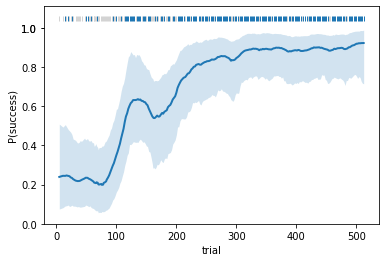

In [ ]:
a = learning.visualize_learning_curves(result)

## method 2: smoothed learning curve

This method is simple and fast. It computes the response probability by sliding a smoothing window over the observations. The user has control about the degree of smoothing by setting the bandwidth of the smoothing kernel. The smoothing is "unbiased", such that only valid observations are taken into account - this reduces the edge effects at the start and end. The function will also compute for each window if the number of correct responses is higher than would be expected by chance and detects the last trial at which this condition occurs as the trial at which learning occurred.

In [ ]:
result1 = learning.smoothed_learning_curve(
    split_trials['in'], chance=0.33, kernel='gaussian',
    alpha=0.01, bandwidth=30)

result2 = learning.smoothed_learning_curve(
    split_trials['out'], chance=0.33, kernel='gaussian',
    alpha=0.01, bandwidth=30)

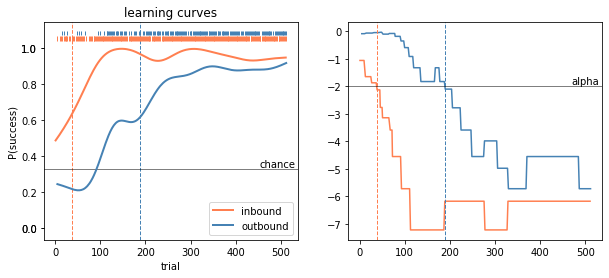

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

a = learning.visualize_learning_curves(
    [result1,result2],
    show=dict(legend=True),
    color=['coral', 'steelblue'],
    ax=ax[0], ylabel='P(success)',
    labels=['inbound', 'outbound'],
    style=dict(incorrect=dict(color='white', linewidth=0))
    );

#annotate
ax[0].axvline(result1['learning_trial'], color='coral', linewidth=1, linestyle='--')
ax[0].axvline(result2['learning_trial'], color='steelblue', linewidth=1, linestyle='--')

labeled_hmarker(0.33, "chance", ax=ax[0], style=dict(linestyle='-',alpha=0.5))

ax[0].set(title="learning curves")

# plot binomial probability
ax[1].plot(result1['learning_curve']['trials'],
           np.log10(result1['other']['binom_pvalue']), color='coral')

ax[1].plot(result2['learning_curve']['trials'],
           np.log10(result2['other']['binom_pvalue']), color='steelblue')

#annotate
ax[1].axvline(result1['learning_trial'], color='coral', linewidth=1, linestyle='--')
ax[1].axvline(result2['learning_trial'], color='steelblue', linewidth=1, linestyle='--')

labeled_hmarker(-2, "alpha", ax=ax[1], style=dict(linestyle='-',alpha=0.5));

## method 3: fit sigmoid learning curve

This methid fits a sigmoid curve or generalized logistic curve to the data:
$$p=baseline + \frac{(target-baseline)}{1 + e^{-rate * (t-midpoint)}}$$
Here, *baseline* is the starting response probability, *target* is the final (learned) response probability, *rate* is the (max) learning rate and *midpoint* is the trial at which the response probability half-way in between *baseline* and *target*. All four parameters are estimated form the data. The model is more constrained than the gaussian random walk and is appropriate as long as the learning curve has a sigmoid shape. Sampling of this model is also relatively fast.

In [ ]:
result4, trace4 = learning.sigmoid_learning_curve(split_trials['in'], baseline=0.33)
result5, trace5 = learning.sigmoid_learning_curve(split_trials['out'], baseline=0.33)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rate, midpoint, target, baseline]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1265.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rate, midpoint, target, baseline]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1238.45draws/s]


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

a = learning.visualize_learning_curves(
    [result4, result5,],
    color=['coral', 'steelblue'],
    show=dict(uncertainty=True, legend=True),
    ax=ax, pct=99,
    labels=['sigmoid inbound', 'sigmoid outbound'],
    );

b = learning.visualize_learning_curves(
    [result1,result2],
    color=['coral', 'steelblue'],
    show=dict(legend=True, responses=False),
    ax=ax,
    labels=['smooth inbound', 'smooth outbound'],
    style=dict(curve=dict(linewidth=1, linestyle='--')),
    );

learning.plot_trial_bands(trialbands, label="session {name}\n(n={size})",
                 names=['a','b','c','d','e','f'], ax=ax)

plt.gca().set_frame_on(False)

# annotations
m = [labeled_hmarker(v, "chance",
                     style=dict(linestyle='-',
                     linewidth=1,
                     color='k')) 
     for v in [0.25, 0.33, 0.5]]


ax.plot([98,126,180], [0.25,0.33,0.5], 'o', color='steelblue')
ax.plot([9,17,38],[0.25,0.33,0.5], 'o', color='coral');

Let's take a closer look at the sampling performance of the parameters. For this, we use pymc3's traceplot function, that plots the distribution and traces of each parameter.

In [ ]:
pm.traceplot(trace5, varnames=['baseline','target','midpoint','rate']);

/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: A

The returned result object contains a summary of the fitted parameters:

In [ ]:
import pprint
pprint.pprint(result5['fit']['parameters'])

{'baseline': {'R': 1.0015152950448754,
              'hpd': array([0.18855629, 0.18968689]),
              'hpd_alpha': 0.01,
              'mean': 0.1635384783450626,
              'median': 0.15667221948151536,
              'mode': 0.1551276829149778},
 'midpoint': {'R': 1.0057307376780078,
              'hpd': array([150.04083537, 150.37548511]),
              'hpd_alpha': 0.01,
              'mean': 146.09337786876392,
              'median': 143.96427144318574,
              'mode': 141.96737000494545},
 'rate': {'R': 1.0003468917956837,
          'hpd': array([0.0178108 , 0.01787296]),
          'hpd_alpha': 0.01,
          'mean': 0.01816489657892442,
          'median': 0.01737023107556069,
          'mode': 0.016619737070748184},
 'target': {'R': 1.0010977540589976,
            'hpd': array([0.88930757, 0.88978276]),
            'hpd_alpha': 0.01,
            'mean': 0.9016297371761616,
            'median': 0.9015736824476354,
            'mode': 0.8978428670462513}}


## method 4: gaussian process

This method makes use of the capabilities of pymc3 to fit a Gaussian Process (GP) to the data. For now, this method has not been tested extensively, and the sampling is rather slow. Future implementation of a sparse Latent model in pymc3 may help to increase speed. The code below is merely provided as an example with T maze and is not ready for production.

In [ ]:
datasets_label = ['inbound', 'outbound']

# number of trials for each session
# note that if you have an ordered array of session numbers for each trial
# (e.g. [1,1,1,2,2,2,3,3,3,3,4,4,4]), then you can use the following to
# create an array of trial number per session:
# np.unique( session_number, return_counts=True)[1]
datasets_sessions = [ [27, 34, 49, 51, 51, 52], [15, 36, 51, 49, 49, 48]]

datasets = []

# inbound trials on T-maze
datasets.append( np.array([0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,1,1,1,0,0,1,0,
                           1,1,1,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,
                           1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,
                           1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,0,1,1,1,1,1,1,1,1,1]))

# outbound trials on T-maze
datasets.append( np.array([0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,
                           0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,
                           0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,
                           0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,
                           1,1,0,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,
                           1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                           1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,
                           1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,
                           1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,
                           1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1]))



In [ ]:
import pymc3 as pm

import theano.tensor as t

def _tinvlogit(x):    
    return t.exp(x) / (1 + t.exp(x))

chance = 0.3
observations = datasets[1]

In [ ]:
Nobs = len(observations)
x = np.arange(Nobs)+1

m = 15. # mode of gamma, represents more or less the width of smoothing kernel (in trials)? 
# gamma
alpha = 5. # shape, alpha>=1, 1: exponential, large values: converges to normal
beta = (alpha-1)/m

# inverse gamma
alpha = 2.
beta = (alpha+1)*m

with pm.Model() as model:
    # covariance function
    #ℓ = pm.Gamma("ℓ", alpha=alpha, beta=beta)
    ℓ = pm.InverseGamma("ℓ", alpha=alpha, beta=beta)
    # informative, positive normal prior on the period
    η = pm.HalfNormal("η", sd=2.)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    gp = pm.gp.Latent(cov_func=cov)
    #gp = pm.gp.TP(cov_func=cov, nu=1)
    
    # make gp prior
    f = gp.prior("f", X=x[:,None])

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=observations)

    trace = pm.sample(50, tune=100, chains=2)#, step=pm.HamiltonianMC(), tune=500, cores=2)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/chaput/miniconda3/envs/fkdev/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using

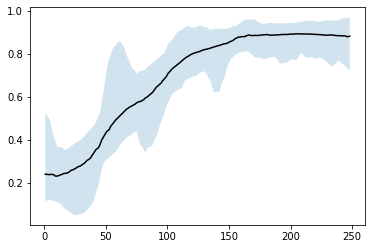

In [ ]:
plt.fill_between(x, np.percentile(trace['p'], 2.5, axis=0), 
                 np.percentile(trace['p'], 97.5, axis=0),alpha=0.2)
plt.plot(x, np.median(trace['p'], axis=0), 'k');

[Text(0, 0.5, 'P(success)'), Text(0.5, 0, 'trial')]

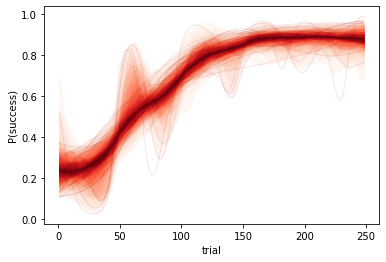

In [ ]:
from pymc3.gp.util import plot_gp_dist
import sys
def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

fig, ax = plt.subplots(1,1)
plot_gp_dist(ax, invlogit(trace["f"]), x);
ax.set(xlabel='trial', ylabel='P(success)')